<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/Project_dm_cleaned().ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
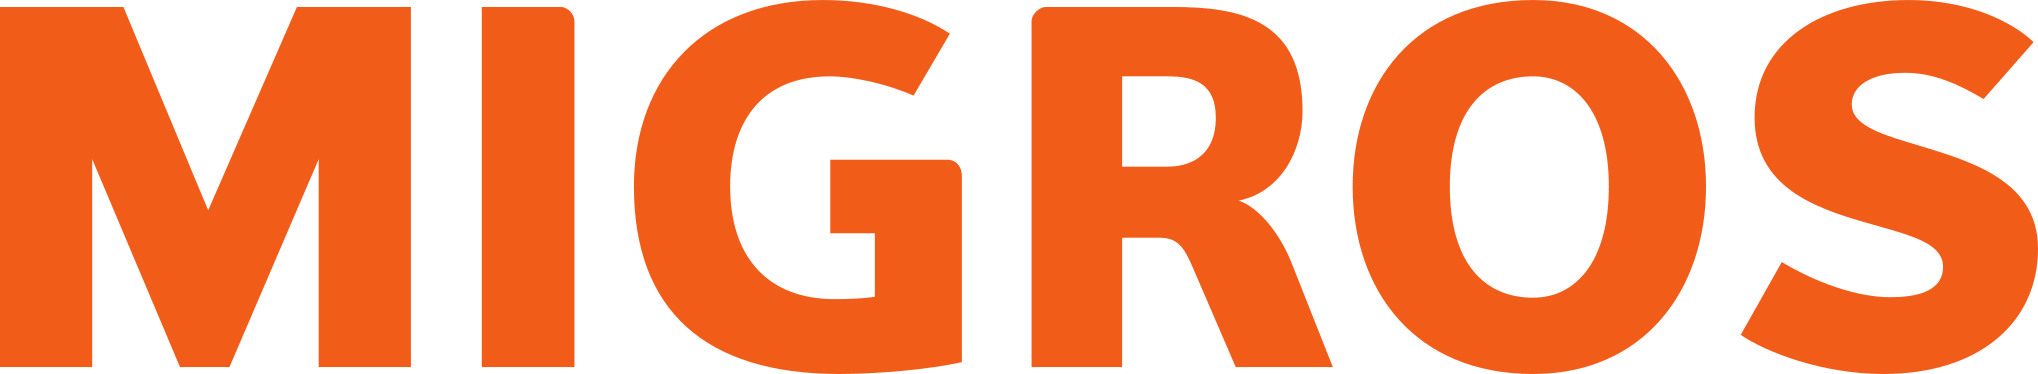
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.

#Report 📋

1) At first we submitted a simple logistic regression without data cleaning which gave us a satisfying accuracy of **0.805** on AICrowd

2) We made EDA on our files in order to be more aware about the database and all its characteristic.
  
3) We cleaned the text by deleting unecessary elements, then applied a logistic regression with cross validation (LRCV). Although the model built on the train data is pretty good, the accuracy on AICrowd got lower: **0.797**

4) We came back on the EDA in order to find if there was something we were missing for the data cleaning. On EDA we find out very frequent words which did not give much information for the analysis quite the opposite represented noise. We deleted them from the text and we ran again the Logistic Regression which increares the test accuracy. We kept going making different combinantion of data cleaning in order to see which one gaves the best result. Previously we cleaned all the nummbers of the text but we realized that making this decreases the model test accuracy. Our hypotesis was that numbers such as dates or ages could give usefull information. Otherwise there was others numbers which represented noise but we weren't able to clean only that part.

4) We used the Random Forest Classifier (RFC) and its model accuracy seemed very promising (0.97 for the train data) however, whilst submitting to AICrowd we got only a result of **0.77**. It seems like we are missing an important point as our accuracy keeps getting lower. Perhaps our model is overfitting the train data, thus we have to correct our parameters

  5) In order to make a good comparison between different model, we realized that was usefull verify every model using cross-validation. We campared four different models and we found out that LogisticRegression was the most accurate for our analysis.

  6) We tried to add keywords on the text column because we thought that this would have add additional information. 

 7) We performed optimized the result using GridsearchCV and we improved the final result at _____.

#Importing useful tools 🧰

In [51]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [2]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en

In [55]:
import spacy
from spacy import displacy

In [54]:
import spacy
from spacy import displacy

In [5]:
!pip install pyspellchecker

In [56]:
from textblob import TextBlob


In [57]:
#clear output
%%capture 

#Importing useful extensions
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

import string
from spellchecker import SpellChecker

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt

#Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [58]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [59]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(6)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
5,10020,twister,NaN,Brain twister let drop up telly structuring ca...


In [61]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

#Exploratory data analysis 🕵️

1. Data base description   
2. Base Rate 
3. Location Exploration 
4. Text exploration 
5. Keywords exploration


####1.Data description 

In [62]:
#shape of data 
print("Shape of data:", df_train.shape)
print ("Number of Rows:", df_train.shape[0])
print ("Number of Columns", df_train.shape[1])

Shape of data: (6471, 5)
Number of Rows: 6471
Number of Columns 5


In [12]:
# Name of columns
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [164]:
#Info 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6471 non-null   int64 
 1   keyword        6416 non-null   object
 2   location       4330 non-null   object
 3   text           6471 non-null   object
 4   target         6471 non-null   int64 
 5   Text_keywords  6471 non-null   object
dtypes: int64(2), object(4)
memory usage: 303.5+ KB


In [127]:
# Sample train_set and test_set
print("Train set sample:", df_train['text'].sample().values[0])
print("Test set sample:", df_test['text'].sample().values[0])

Train set sample: enjoy the impending landslide todd. hehe.
Test set sample: inws alert spsgsp from 8/5/2015 10:40 pm to 11:15 pm edt for pickens county: strong thunderstorm will impact... 


In [13]:
# Null values 
df_train.isnull().sum()

id             0
keyword       55
location    2141
text           0
target         0
dtype: int64

####2. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [63]:
# Number of tweets in df_train  that support or not a real disaster 
Tweets_support = len(df_train[df_train['target'] == 1])
Tweets_does_not_support = len(df_train[df_train['target'] == 0])
print("Number of tweets that does not support a real disaster : ", Tweets_does_not_support)
print("Number of tweets that support a real disaster:", Tweets_support)

Number of tweets that does not support a real disaster :  3701
Number of tweets that support a real disaster: 2770


In [15]:
#Base rate of the train df
r = df_train['target'].value_counts() /len(df_train) 
print("Base rate =", max(r))

Base rate = 0.5719363313243703


####3. Location 

In [16]:
df_train['location']

0                         USA
1                         NaN
2       Palm Beach County, FL
3                         USA
4                  Australia 
                ...          
6466                ARGENTINA
6467                      NaN
6468                      NaN
6469           Beirut/Toronto
6470                      NaN
Name: location, Length: 6471, dtype: object

In [17]:
len(df_train['location'])

6471

In [18]:
#Location null values
df_train.location.isnull().sum()

2141

In [21]:
# Number of location
loc_len =len(df_train['location'].unique())
print("Number of locations:", loc_len)

Number of locations: 2922


####4. Keywords

In [ ]:
df_train['keyword']

0                   destroyed
1                   bioterror
2                   windstorm
3                   hazardous
4                     hostage
                ...          
6466               earthquake
6467                   derail
6468                  trapped
6469                  weapons
6470    buildings%20on%20fire
Name: keyword, Length: 6471, dtype: object

In [39]:
#Location null values
df_train.keyword.isnull().sum()

0

In [40]:
#Length of Location
len(df_train['keyword'])

6387

####3. Text Exploration


In [ ]:
# Total number of word 
print("Total Number of Words:", df_train['text'].apply(lambda x: len(x.split(' '))).sum())
# Total number of word test_set
print("Total Number of Words test set:", df_test['text'].apply(lambda x: len(x.split(' '))).sum())

Total Number of Words: 96544
Total Number of Words test set: 17110


In [ ]:
# Check duplicates 
print('Entire Duplicated rows:', df_train.duplicated().sum())
print('Duplicated Text:', df_train['text'].duplicated().sum())
print('Duplicated Keywords:', df_train['keyword'].duplicated().sum())
print('Duplicate Locations:', df_train['location'].duplicated().sum())

Entire Duplicated rows: 0
Duplicated Text: 0
Duplicated Keywords: 6165
Duplicate Locations: 3479


In [66]:
# Df_train grouped text message by target 
df_train_grouped =df_train[['target','text']].groupby(by='target').agg(lambda x: ' '.join(x))
corpus = df_train_grouped['text']
corpus0 = corpus[[0]]
corpus1 = corpus[[1]]
print(corpus)

target
0    Black Eye 9: A space battle occurred at Star O...
1    Reality Training: Train falls off elevated tra...
Name: text, dtype: object


In [67]:
# Number of words in Tweets that does/does not support real disaster 
print("Number of Words tweets does not support Real disaster:", corpus0.apply(lambda x: len(x.split(' '))).sum())
print("Total Number of Words tweets does support Real disaster:", corpus1.apply(lambda x: len(x.split(' '))).sum())

Number of Words tweets does not support Real disaster: 54373
Total Number of Words tweets does support Real disaster: 42171


####4. Most common Words exploration


The following barcharts shows most common words in Tweets. This analisis can help us finding words which are very frequent in whole Tweets but that do not give much information for the Classification. The first thing that we can notice is that most frequent words are Stopwords, this kind of words do not give information so the have to be removed. Second thing that can be noticed are words like "ù_" "http" "https" "amp" or "co" that are extremely frequent in the database but did not give much information quite the opposite they represent disturbance, for that reason they have to be removed in order to improve accuracy results. 

In [68]:
# Function that find most common words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [69]:
Whole_tweets_most_common_words = get_top_n_words(corpus, 35)
Tweets_0_most_common_words = get_top_n_words(corpus0, 35)
Tweets_1_most_common_words = get_top_n_words(corpus1, 33)
print("Corpus:", Whole_tweets_most_common_words)
print("Corpus 0 :", Tweets_0_most_common_words)
print("Corpus 1 :", Tweets_1_most_common_words)

Corpus: [('co', 4038), ('http', 3663), ('the', 2755), ('in', 1687), ('to', 1649), ('of', 1547), ('and', 1189), ('is', 811), ('you', 769), ('for', 754), ('on', 736), ('it', 658), ('my', 597), ('that', 521), ('with', 496), ('by', 465), ('at', 451), ('this', 402), ('https', 355), ('from', 354), ('are', 341), ('be', 335), ('was', 333), ('have', 329), ('û_', 295), ('amp', 294), ('like', 290), ('me', 287), ('as', 283), ('just', 282), ('up', 278), ('but', 275), ('so', 271), ('not', 253), ('your', 253)]
Corpus 0 : [('co', 1892), ('http', 1645), ('the', 1600), ('to', 998), ('and', 762), ('of', 754), ('in', 700), ('you', 642), ('is', 513), ('my', 479), ('it', 454), ('for', 416), ('on', 370), ('that', 345), ('with', 333), ('this', 248), ('https', 239), ('be', 235), ('me', 233), ('by', 219), ('have', 207), ('so', 206), ('like', 206), ('just', 204), ('are', 201), ('your', 198), ('at', 195), ('was', 189), ('but', 188), ('amp', 176), ('can', 174), ('not', 173), ('out', 169), ('up', 166), ('all', 165)

In [70]:
df =  pd.DataFrame(Whole_tweets_most_common_words, columns= ['Token', 'Frequency'])
df1 = pd.DataFrame(Tweets_1_most_common_words, columns= ['Token', 'Frequency'])
df0 = pd.DataFrame(Tweets_0_most_common_words, columns= ['Token', 'Frequency'])

In [71]:
# Most frequent 10 words in tweets that support real disaster 
def barchart_most_frequent_words(data, title):
    plt.style.use('dark_background')
    token= data['Token']
    frequency = data['Frequency']
    plt.bar(token, frequency)
    plt.title(title)
    plt.xlabel('Most frequent Words')
    plt.ylabel('Frequency')
    return plt.show()

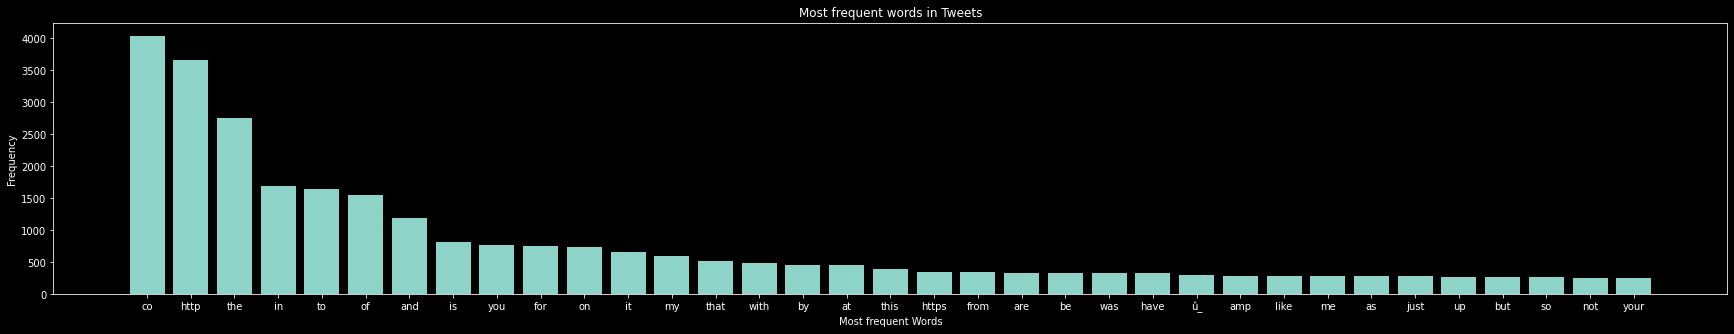

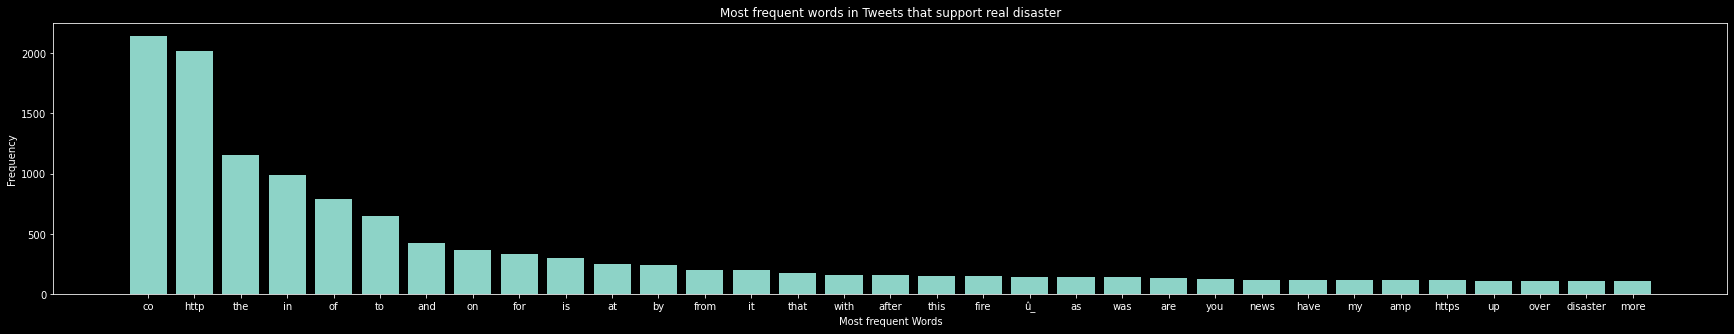

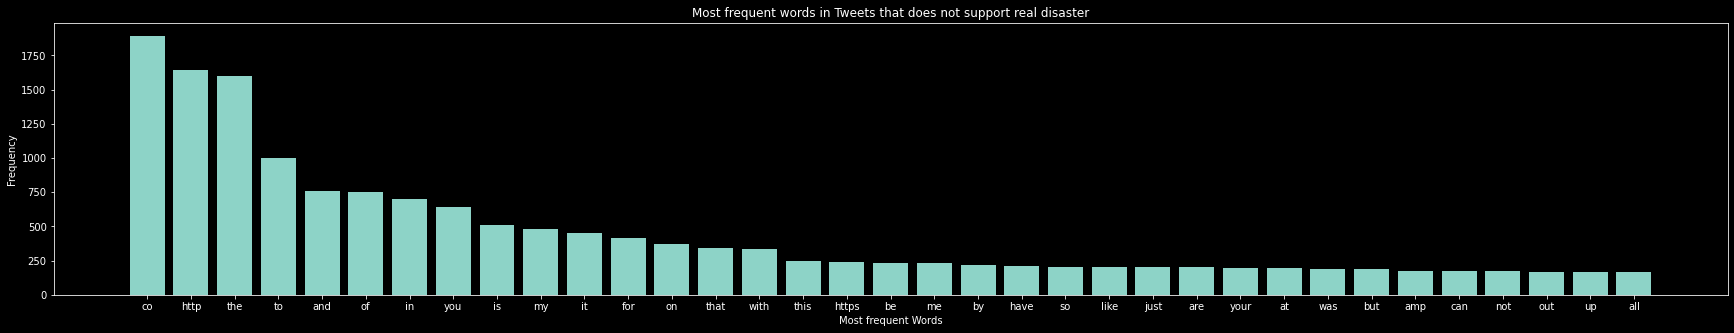

In [72]:
plt.rcParams['figure.figsize']= (30, 5)
# Barchart Most important word 
barchart_most_frequent_words(df, 'Most frequent words in Tweets')
barchart_most_frequent_words(df1, 'Most frequent words in Tweets that support real disaster')
barchart_most_frequent_words (df0, 'Most frequent words in Tweets that does not support real disaster')

#Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column

In [73]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

# Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
# Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
# Remove words with two letters or less
    mytokens = [ word for word in mytokens if len(word)>2 ]   
# Return preprocessed list of tokens
    return mytokens
#demo
review = df_train["text"].sample()
review.values[0]


'master0fsloths has a crush: http://t.co/SZX6v0bbjF'

#Logistic regression and pipeline before data cleaning 

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.



In [74]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [76]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100, random_state=72)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [77]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...b',
                                 tokenizer=<function spacy_tokenizer at 0x7f29d20ada60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit

####Accuracy

In [78]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8905
CONFUSION MATRIX:
[[2862   85]
 [ 482 1747]]


In [79]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.8093
CONFUSION MATRIX:
[[665  89]
 [158 383]]


####Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [84]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value ='nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

0

In [85]:
#Using keyword in the model


X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [86]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100, random_state=72)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])



In [87]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...b',
                                 tokenizer=<function spacy_tokenizer at 0x7f29d20ada60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit

In [88]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.7374
CONFUSION MATRIX:
[[2375  572]
 [ 787 1442]]


In [89]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7181
CONFUSION MATRIX:
[[581 173]
 [192 349]]


#Data cleaning 🧼
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [90]:
#Need to replace NaN values by blank spaces otherwise some funtions wont run  ----> is it right only on df_test ? 
df_test['text'] = df_test['text'].replace(np.nan, '')


In [91]:
#Clean duplicates
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)


#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#removing hashtags
def remove_hash(text):
  text = re.sub('#','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_hash(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hash(x))

#removing amp
def amp(text):
  text = re.sub('&amp;', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: amp(x))
df_test['text'] = df_test['text'].apply(lambda x: amp(x))

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))



In [92]:
#removing other noises
def remove_noise(text):
  text = re.sub('RT ', '', text)
  text = re.sub(' co ', '', text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))


In [93]:

# Remove other strange characters noise
def remove_noise_1(text):
  
  text = re.sub(' & ', '', text)
  text = re.sub(' û_ ', '',text)
  text = re.sub(' û ', '', text)
  text = re.sub('&', '', text)
  text = re.sub('', '', text)
  text = re.sub('ª', '', text)
  text = re.sub(' ûªs ', '',text)

  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))

#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))

## Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))


In [ ]:
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_single_characters(x))
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_uppercase(x))
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_multiple_spaces(x))
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_noise_1(x))
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_noise(x))
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: remove_url(x)
df_test['Text_keywords'] = df_test['Text_keywords'].apply(lambda x: amp(x))
df_train['Text_keywords']=df_test['Text_keywords'].replace('%20', ' ', regex = True)

I did not use Following text cleaning methods because they made accuracy worst. 


- Stopwords are surely helpull in order to improve the result but in 

```
# Remove Stopwords
def remove_stopword(text):
  text= remove_stopwords(text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_stopword(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopword(x))


```



- Removing all the numbers makes prediction worse. That could be because of dates and ages which provides usefull information to the machine learning algorithm. 

```
# remove digits
def remove_digits(text):
  text = re.sub(r"\d", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_digits(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_digits(x))


```


```

#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub(r"[0-9]+", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))


```





- Removing all the numbers makes prediction worse Maybe we have to mantain dates and remove only  "strange" numbers? (if so HOOOOOW?) 





#Logistic regression and pipeline after Data cleaning 

Our second iteration of the model: *treatement of the dataframe with text cleaning*, fitted in a logistic regression to see the result.



In [100]:
#Setting up the train test split
#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [101]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [102]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [103]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7f29d20ada60>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [106]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8843
CONFUSION MATRIX:
[[2831   93]
 [ 498 1687]]


In [107]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.8146
CONFUSION MATRIX:
[[676  76]
 [161 365]]


In [31]:
target_test = pipe.predict(df_test['text'])
target_test =pd.DataFrame(target_test)
target_test

,0
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [249]:
sample_submission.assign(target = target_test)
target_test.to_csv('submission_newparams.csv', index=False)


#Optimize the parameters of the TfidfVectorizer

In these chapter we are going to see if there are TF-IDF parameters who works better for our analysis. We proceed by running a logistic regression with a random_state=72 for every combination of the tf-idf parameters. Finally we are going to build our optimized vectorizer.

In [113]:
# Evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [114]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1), (1,2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)]
    min_df = [1]
    max_df = [1.0]
    analyzer=['word', 'char']
    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                    cfg = [n, i, j, a]
                    models.append(cfg)
    return models

configs = configs()

In [115]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
CONFUSION MATRIX:
[[676  76]
 [161 365]]
ACCURACY SCORE:
0.8146
CLASSIFICATION REPORT:
	Precision: 0.8277
	Recall: 0.6939
	F1_Score: 0.7549
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
CONFUSION MATRIX:
[[580 172]
 [242 284]]
ACCURACY SCORE:
0.6761
CLASSIFICATION REPORT:
	Precision: 0.6228
	Recall: 0.5399
	F1_Score: 0.5784
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[674  78]
 [164 362]]
ACCURACY SCORE:
0.8106
CLASSIFICATION REPORT:
	Precision: 0.8227
	Recall: 0.6882
	F1_Score: 0.7495
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[630 122]
 [196 330]]
ACCURACY SCORE:
0.7512
CLASSIFICATION REPORT:
	Precision: 0.7301
	Recall: 0.6274
	F1_Score: 0.6748
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
CONFUSION MATRIX:
[[675  77]
 [168 358]]
ACCURACY SCORE:
0.8083
CLASSIFICATION REPORT:
	Precision: 0.8230
	Recall: 0.6806
	F1_Score: 0.7451
-----------------------
CONFIG:  [

In [ ]:
# Improved TF-IDF tokenizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

### From this analysis we find out that there is some parameters that works better then the default ones specifically:
- ngram_range: (3, 4)
- min_df: 1
- max_df:  1.0
- Analyzer: 'char'


Improvement in test accurancy score from ____ to _____

So for the rest of our analysis we keep always these parameters for td-ifd

#K-Fold cross-validation
We have seen that the accurancy result from the Logistic regression can present significat change based on the split of the train_ test data(from about 0.78 to 0.82). In fact the train_test split change every time we run the code and also if we set a random_state for comparing results before and after data cleaning,  the result did not reflect the exact accuracy score of the model making difficult the comparison with others methods.
For that reason we decided to use k-fold cross validation for the test train split which allows us to optain a more reliable model accuracy. 

In [117]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Cross validation Model selection 👨‍💻

We tried different classifier to know which one could predict better our model. In Addition in this part we tried also all the models adding keywords to the text column because we taught that this could give some additional information. The different models that we have tried are the following:
1. Logistic Regression 
2. RandomForrest Classifier
3. KNN 


####1. Logistic Regression with cross-validation 

In [126]:
# define features 
X = df_train['text']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [130]:
# 10-fold cross-validation with the logistic regression
scores =cross_val_score(LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72, C=2.6), X_tdf_vec, y, cv=10, scoring='accuracy')
scores = np.array(scores)
print('Score_mean:', np.mean(scores))
print('Score_sdt:', np.std(scores))

Score_mean: 0.8097735489916161
Score_sdt: 0.017335042767657658


#### We tried to add keywords on the text column to see if there was some improvement

In [131]:
df_train['Text_keyword'] = (df_train['keyword'] + ' ' +  df_train['text']).astype(str)

In [132]:
# define features 
X = df_train['Text_keyword']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [133]:
# 10-fold cross-validation with the logistic regression
scores =cross_val_score(LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72, C=2.6), X_tdf_vec, y, cv=10, scoring='accuracy')
scores = np.array(scores)
print('Score_mean:', np.mean(scores))
print('Score_sdt:', np.std(scores))

Score_mean: 0.8093006313744535
Score_sdt: 0.01984641898471786


####2. Random Forrest classifier with cross-validation 🌳🌳🌳

####RandomForrest on Text

In [134]:
# define features 
X = df_train['text']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [135]:
#10- fold cross-validation with the random forrest classifier
scores_lrcv =cross_val_score(RandomForestClassifier(), X_tdf_vec, y, cv=10, scoring='accuracy')
scores_lrcv = np.array(scores_lrcv)
print('Score_mean:', np.mean(scores_lrcv))
print('Score_sdt:', np.std(scores_lrcv))

Score_mean: 0.7855038976457139
Score_sdt: 0.01779507566966163


####RandomForrest on Text + keywords


In [137]:
# define features 
X = df_train['Text_keyword']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [138]:
#10- fold cross-validation with the random forrest classifier
scores_lrcv =cross_val_score(RandomForestClassifier(), X_tdf_vec, y, cv=10, scoring='accuracy')
scores_lrcv = np.array(scores_lrcv)
print('Score_mean:', np.mean(scores_lrcv))
print('Score_sdt:', np.std(scores_lrcv))

Score_mean: 0.7922375773274267
Score_sdt: 0.019456920788124277


####3. KNN model with cross validation
- KNN using text column
- KNN using text + keyword column 

##### KNN Using text column

In [139]:
# define features 
X = df_train['text']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [140]:
# 10-fold cross-vaidation KNN model k=15
knn = KNeighborsClassifier(n_neighbors=27)
scores_knn =cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
scores_knn =np.array(scores_knn)
print('Score_mean:', np.mean(scores_knn))
print('Score_std:',  np.std(scores_knn))

Score_mean: 0.7834670159585168
Score_std: 0.023888392538064195


In [141]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores= cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

Text(0, 0.5, 'Cross-validated accuracy')

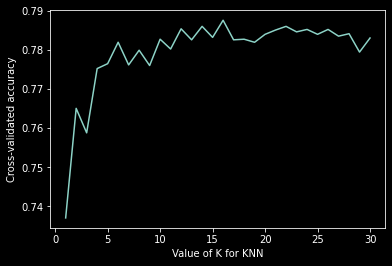

In [142]:
%matplotlib inline
# Plot how accuracy changes as we vary k
plt.style.use('dark_background')
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

#####KNN using text column + Keyword 

In [143]:
# define features 
X = df_train['Text_keyword']
y = df_train['target']
# Define vectorizer 
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')
X_tdf_vec = tfidf_vector.fit_transform(X)

In [144]:
# 10-fold cross-vaidation KNN model k=15
knn = KNeighborsClassifier(n_neighbors=27)
scores_knn =cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
scores_knn =np.array(scores_knn)
print('Score_mean:', np.mean(scores_knn))
print('Score_std:',  np.std(scores_knn))

Score_mean: 0.7469836784552666
Score_std: 0.019971738654797736


In [145]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores= cross_val_score(knn, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

Text(0, 0.5, 'Cross-validated accuracy')

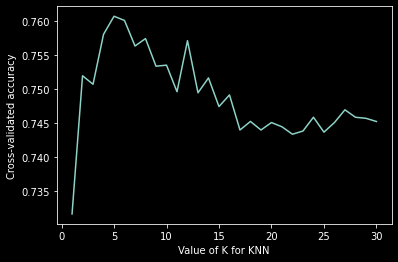

In [146]:
%matplotlib inline
# Plot how accuracy changes as we vary k
plt.style.use('dark_background')
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

#Logistic regression improvement 
From the model selection we have decided to focus on Logistic regression, which has performed the best accurancy, and try to improve the accuracy by selecting best parameters. 
In order to achieve a better result we proceed as follow: 
- Exploration of Logistic regression parameters
- Optimize TF-IDF parameters
- optimize logistic regression parameters with gridSearchCV 
- Try some dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)


### Exploring Logistic Regression Parameters scores using cross
We are going to do this analisis in order to see how accuracy change by changing LogisticRegression parameters. This is only an explanatory analisis, we will do the optimization of the parameters at the end using GridsearchCV

In [ ]:
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

#### Logistic Regression Parameter: Solver 

In [147]:
# search for an optimal solver 

# Type of solver we want to try 
solvers= ['lbfgs', 'saga', 'sag', 'liblinear', 'newton-cg'] 
# empty list to store scores
solver_scores = []

# 1. we will loop through type of solver 
for k in solvers:
    # 2. run logistic Regression  with k solver
    LR = LogisticRegression(solver=k)
    # 3. obtain cross_val_score for Logistic Regression  with k Solver
    scores= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k solver to solver_scores list
    solver_scores.append(scores.mean())

Text(0, 0.5, 'Score')

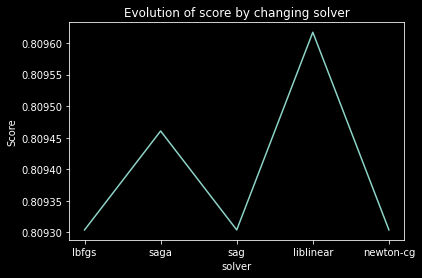

In [148]:
plt.style.use('dark_background')
plt.title('Evolution of score by changing solver')
plt.plot(solvers, solver_scores)
plt.xlabel('solver')
plt.ylabel('Score')

####Logistic regression parameter C

In [149]:
#search for optimal C parameter 

C_param = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8, 2.9, 3.0]
C_score= []
# 1. we will loop through reasonable values of C
for k in C_param:
    # 2. run LogisticRegression  with value of C=k
    LR = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=72, C=k)
    # 3. obtain cross_val_score for LogisticRegression with value of C=k 
    scores_C= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for C=k to C_score list
    C_score.append(scores_C.mean())
  

Text(0, 0.5, 'Score')

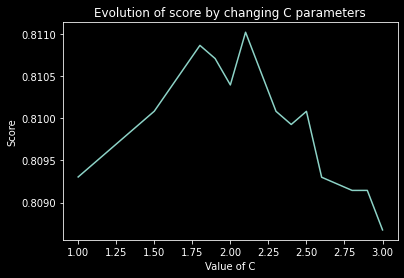

In [150]:
# Plot
C_param_d = pd.DataFrame(C_param)
C_score_d = pd.DataFrame(C_score)
C_param_d['score'] = C_score_d
plt.style.use('dark_background')
plt.title('Evolution of score by changing C parameters')
plt.plot(C_param, C_score)
plt.xlabel('Value of C')
plt.ylabel('Score')

#### LogisticRegression parameter: Max_iteration 

In [151]:
#search for optimal max_iter
# range of k we want to try
 
# empty list to store scores
max_iter = [100, 200, 500, 1000, 2000]
max_iter_score= []
# 1. we will loop through reasonable values of max_iter
for k in max_iter:
    # 2. run LogisticRegression with max_iter=k
    LR = LogisticRegression(solver='lbfgs', max_iter=k, random_state=72, C=2.6)
    # 3. obtain cross_val_score for LogisticRegression with max_iter= k
    scores_iter= cross_val_score(LR, X_tdf_vec, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for max_iter=k
    max_iter_score.append(scores_iter.mean())

Text(0, 0.5, 'Score')

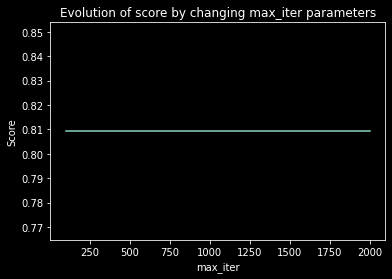

In [152]:
#Plot
plt.style.use('dark_background')
plt.title('Evolution of score by changing max_iter parameters')
plt.plot(max_iter, max_iter_score)
plt.xlabel('max_iter')
plt.ylabel('Score')

###Optimize logistic regression parameters with gridSearchCV 
The above logistic regression was run with the default parameters.In this chapter we are trying to improve the accurancy by tuning the hyperparameters using the "GridSearch" method. 
We run the logistic regression using the TF-IDF vectorizer with the optimized parameters. 


In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test
X_train_vec = tfidf_vector.fit_transform(X_train)
X_test_vec = tfidf_vector.transform(X_test)
X_test_vec_s = tfidf_vector.transform(df_test['text'])
print(X_train_vec.shape)
print(X_test_vec.shape)
print(X_test_vec_s.shape)
X_train_vec

(5109, 58770)
(1278, 58770)
(1142, 58770)


<5109x58770 sparse matrix of type '<class 'numpy.float64'>'
	with 758678 stored elements in Compressed Sparse Row format>

In [154]:
# Gridsearch Logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,  datasets

parameters = dict({'solver': ['lbfgs', 'saga', 'liblinear'], 'C':[1, 10]})
LR = LogisticRegression(max_iter=1000, random_state=72)

clf = GridSearchCV(
    LR, parameters, scoring='accuracy'
    )
best_clf = clf.fit(X_train_vec, y_train)

In [155]:
best_clf

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=72, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10],
                         'solver': ['lbfgs', 'saga', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [157]:
y_pred_test_vec = best_clf.predict(X_test_vec)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test_vec):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test_vec)}")

TEST ACCURACY SCORE:
0.8146
CONFUSION MATRIX:
[[687  65]
 [172 354]]


In [158]:
y_pred_test_vec = best_clf.predict(X_test_vec_s)
y_pred_test_vec

array([0, 0, 1, ..., 1, 0, 1])

In [159]:
target_test = best_clf.predict(X_test_vec_s)
target_test =pd.DataFrame(target_test)
target_test

,0
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
sample_submission.assign(target = target_test)
target_test.to_csv('submission_gridsearch.csv', index=False)


### Dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import time

In [161]:
# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

In [162]:
# Vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test
X_train_vec = tfidf_vector.fit_transform(X_train).toarray()
X_test_vec = tfidf_vector.fit_transform(X_test).toarray()
print(X_train_vec.shape)
print(X_train_vec)
print(X_test_vec.shape)


(5109, 58770)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1278, 30234)


###PCA

In [163]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=2000)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)

In [164]:
print('Shape after PCA: ', X_train_vec_pca)
print('Number of components:', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  [[-1.19580568e-01  8.73345745e-02  2.06730660e-01 ...  9.42808323e-04
   1.10438062e-04  8.13643012e-04]
 [-2.96510728e-02  7.75859761e-02 -4.22614709e-02 ...  6.47622995e-03
   2.83409923e-03  8.06113066e-03]
 [-9.43125417e-03  3.33307239e-02 -3.67782329e-02 ...  8.14746141e-03
  -2.11423698e-02  4.77962945e-03]
 ...
 [-1.69496613e-02  1.16579013e-02 -3.31769117e-03 ... -1.73354896e-04
  -9.73410797e-04  5.29308679e-03]
 [ 2.57629279e-03 -3.75593995e-02 -2.43630884e-03 ...  9.07199971e-05
   4.38102536e-03  2.79207930e-02]
 [ 1.63390728e-03 -8.87691656e-02  4.67873196e-02 ...  8.02474039e-03
  -7.60547031e-03  1.73195832e-03]]
Number of components: 2000
Explained variance ratio:  0.8069865781078029


###Logistic regression 
- With standardisation


In [ ]:
# With Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time
 # Define classifier
LR = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=72)
# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegression())
                 ])

# Fit model
pipe.fit(X_train_vec, y_train)
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy:  0.9979
Test Accuracy:  0.7398


In [165]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  465.752
Train Accuracy:  0.8657


ValueError: ignored

In [ ]:
print(X_test_vec.shape)
print(y_test.shape)

(1278, 30376)
(1278,)


In [ ]:
print(X_train_vec.shape)
print(y_train.shape)

(5109, 59028)
(5109,)


In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=5000)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

NameError: ignored

In [ ]:
# With PCA and standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

NameError: ignored

##Submission 👀
This is the code that we use to create the submission. To use it, we can just copy/paste it below the classifier of our choice and rename the .csv file.

In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

In [ ]:
sample_submission.assign(target = target_test)
sample_submission.to_csv('submission-n.csv', index=False)